In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from torch_geometric.nn import GCNConv

# Define the Model
class BERT_HierarchicalAttentionFusion(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_dim=768, gcn_hidden_dim=256, num_classes=2):
        super(BERT_HierarchicalAttentionFusion, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Attention weights for question, context, and answer
        self.attention_weights = nn.Parameter(torch.randn(3))

        # Graph Convolutional Network layers
        self.gcn1 = GCNConv(hidden_dim, gcn_hidden_dim)
        self.gcn2 = GCNConv(gcn_hidden_dim, hidden_dim)

        # Classification layer
        self.classifier = nn.Linear(hidden_dim, num_classes)

        self.relu = nn.ReLU()

    def forward(self, input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index):
        # Extract BERT embeddings for question, context, and answer
        e_q = self.bert(input_ids=input_ids_q, attention_mask=attention_mask_q).pooler_output
        e_c = self.bert(input_ids=input_ids_c, attention_mask=attention_mask_c).pooler_output
        e_a = self.bert(input_ids=input_ids_a, attention_mask=attention_mask_a).pooler_output

        # Attention-based fusion
        attention_scores = torch.softmax(self.attention_weights, dim=0)
        f_fused = (attention_scores[0] * e_q + attention_scores[1] * e_c + attention_scores[2] * e_a)

        # Graph-based fusion
        embeddings = torch.stack([e_q, e_c, e_a], dim=1)  # Change shape from [batch, 3, hidden_dim] -> [3, batch, hidden_dim]

        # First GCN layer
        h = self.gcn1(embeddings.mean(dim=1), edge_index)
        h = self.relu(h)

        # Second GCN layer
        h = self.gcn2(h, edge_index)

        # Refine fused feature with GCN output
        f_final = f_fused + h.mean(dim=0)

        # Classification
        logits = self.classifier(f_final)

        return logits


In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = pd.read_excel("/content/finaldataset.xlsx")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class LegalQADataset(Dataset):
    def __init__(self, df):
        self.questions = df["Question"].to_list()
        self.contexts = df["Context"].to_list()
        self.answers = df["Answer"].to_list()
        self.labels = df["Label"].to_list()  # Assuming a column 'Label' (0=open-ended, 1=closed-ended)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q = self.questions[idx]
        c = self.contexts[idx]
        a = self.answers[idx]
        label = self.labels[idx]

        inputs_q = tokenizer(q, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        inputs_c = tokenizer(c, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        inputs_a = tokenizer(a, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        return {
            "input_ids_q": inputs_q["input_ids"].squeeze(0),
            "attention_mask_q": inputs_q["attention_mask"].squeeze(0),
            "input_ids_c": inputs_c["input_ids"].squeeze(0),
            "attention_mask_c": inputs_c["attention_mask"].squeeze(0),
            "input_ids_a": inputs_a["input_ids"].squeeze(0),
            "attention_mask_a": inputs_a["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Create dataset
dataset = LegalQADataset(df)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [ ]:
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = BERT_HierarchicalAttentionFusion().to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Gradient Scaler for AMP
scaler = GradScaler()

# Edge Index (Fixed for all batches)
edge_index = torch.tensor([[0, 1, 1, 2, 2, 0], [1, 0, 2, 1, 0, 2]], dtype=torch.long).to(device)

# Training loop
epochs = 3
train_losses=[]
test_losses=[]
for epoch in range(epochs):
    model.train()
    running_loss=0

    for batch in dataloader:
        optimizer.zero_grad()

        # Move batch to device
        input_ids_q = batch["input_ids_q"].to(device)
        attention_mask_q = batch["attention_mask_q"].to(device)
        input_ids_c = batch["input_ids_c"].to(device)
        attention_mask_c = batch["attention_mask_c"].to(device)
        input_ids_a = batch["input_ids_a"].to(device)
        attention_mask_a = batch["attention_mask_a"].to(device)
        labels = batch["label"].to(device)

        with autocast():
            logits = model(input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index)
            loss = criterion(logits, labels)
            running_loss += loss.item()

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()
    train_losses.append(running_loss / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

print("Training complete!")


<ipython-input-23-60897165ae35>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-23-60897165ae35>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3, Loss: 0.263031005859375
Epoch 2/3, Loss: 0.42388916015625
Epoch 3/3, Loss: 0.06597137451171875
Training complete!


In [ ]:
# Test DataLoader (Replace this with your actual test dataloader)
test_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Testing Loop
model.eval()
test_loss = 0
correct = 0
total = 0
for i in range(3):

  with torch.no_grad():
      for batch in test_dataloader:
          input_ids_q = batch["input_ids_q"].to(device)
          attention_mask_q = batch["attention_mask_q"].to(device)
          input_ids_c = batch["input_ids_c"].to(device)
          attention_mask_c = batch["attention_mask_c"].to(device)
          input_ids_a = batch["input_ids_a"].to(device)
          attention_mask_a = batch["attention_mask_a"].to(device)
          labels = batch["label"].to(device)

          logits = model(input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index)
          loss = criterion(logits, labels)
          test_loss += loss.item()

          # Compute Accuracy
          predictions = torch.argmax(logits, dim=1)
          correct += (predictions == labels).sum().item()
          total += labels.size(0)

  # Compute Average Test Loss
  test_loss /= len(test_dataloader)
  test_losses.append(test_loss)
accuracy = correct / total * 100

print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


Test Loss: 0.1735, Accuracy: 94.94%


In [ ]:
print(test_losses)
print(train_losses)

[0.002888662616411845, 0.006536955303615994, 0.008293171723683676, 0.009654521031512155, 0.010373779882987341, 0.02225719764828682, 0.025831154733896255, 0.028871114138099882, 0.030590944902764428, 0.035701152433951694, 0.03700856525037024, 0.03806666549709108, 0.03861155915591452, 0.03912791369689835, 0.03996120931373702, 0.0412702394856347, 0.04472912185721927, 0.04641884118318558, 0.047070386053787334, 0.049291652316848435, 0.05055342072414027, 0.05444314533637629, 0.05841810624632571, 0.06586546090741953, 0.06766458041965961, 0.06857666071090433, 0.07095759208831522, 0.072075153928664, 0.07465486216048399, 0.07762346685760552, 0.07841869720982181, 0.0791599490162399, 0.07983043185538716, 0.08051130899952517, 0.08111121468245983, 0.08179852155347665, 0.08238401491608885, 0.0830938071426418, 0.08427914103700054, 0.08722436283197668, 0.08861476137406296, 0.09197719879448414, 0.09351336662140157, 0.09449691801435417, 0.09544683425790734]
[24.90185546875, 16.926860809326172, 10.39206695

In [ ]:
from torch.utils.data import DataLoader, random_split

# Assuming `dataset` is your full dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


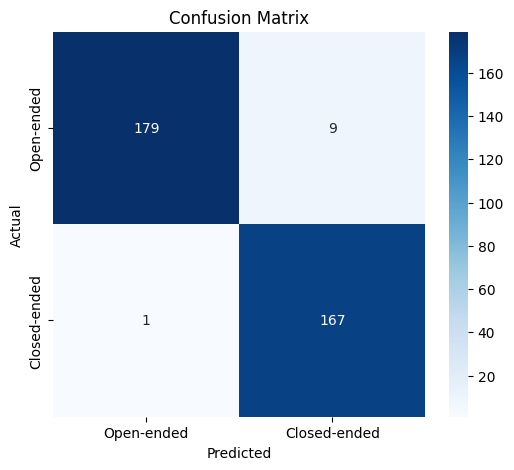

              precision    recall  f1-score   support

  Open-ended     0.9944    0.9521    0.9728       188
Closed-ended     0.9489    0.9940    0.9709       168

    accuracy                         0.9719       356
   macro avg     0.9717    0.9731    0.9719       356
weighted avg     0.9729    0.9719    0.9719       356



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    test_loss=0
    with torch.no_grad():
        for batch in dataloader:
            input_ids_q = batch["input_ids_q"].to(device)
            attention_mask_q = batch["attention_mask_q"].to(device)
            input_ids_c = batch["input_ids_c"].to(device)
            attention_mask_c = batch["attention_mask_c"].to(device)
            input_ids_a = batch["input_ids_a"].to(device)
            attention_mask_a = batch["attention_mask_a"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index)
            loss = criterion(logits, labels)
            test_loss += loss.item()

            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_losses.append(test_loss / len(test_dataloader))

    return np.array(all_preds), np.array(all_labels)

# Get Predictions
test_preds, test_labels = evaluate_model(model, test_dataloader, device)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Open-ended', 'Closed-ended'], yticklabels=['Open-ended', 'Closed-ended'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print(classification_report(test_labels, test_preds, target_names=['Open-ended', 'Closed-ended'], digits=4))


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_attention_weights(model):
    attention_scores = F.softmax(model.attention_weights, dim=0).detach().cpu().numpy()
    labels = ["Question", "Context", "Answer"]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, attention_scores, color=['blue', 'green', 'red'])
    plt.xlabel("Input Components")
    plt.ylabel("Attention Score")
    plt.title("Hierarchical Attention Distribution")
    plt.ylim(0, 1)
    plt.show()

# Call this after training
visualize_attention_weights(model)


NameError: name 'model' is not defined

In [ ]:
def plot_loss_curve(train_losses, test_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(test_losses, label="Test Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Test Loss Curve")
    plt.legend()
    plt.show()


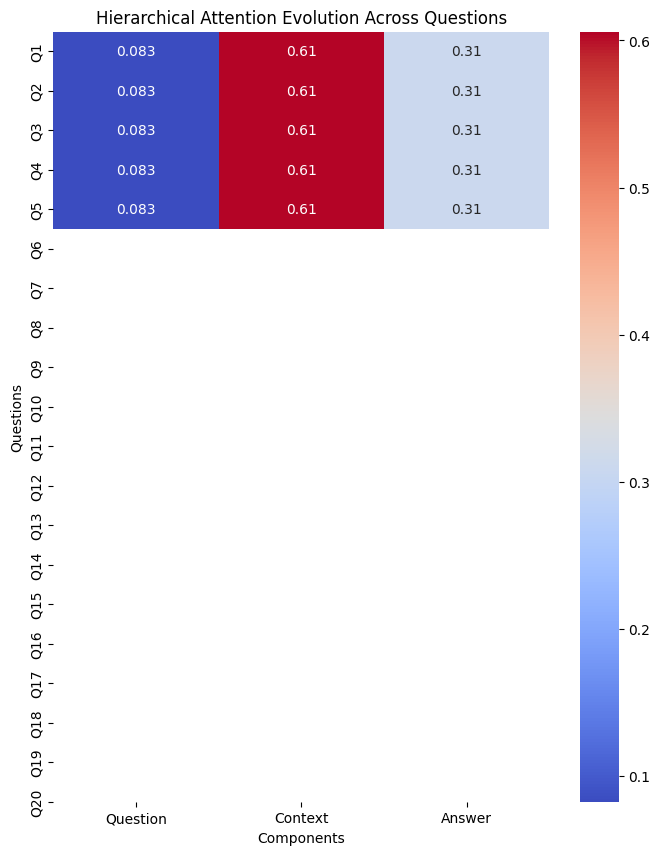

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_attention_matrix(model, dataloader, num_samples=20):
    model.eval()
    attention_weights_list = []

    with torch.no_grad():
        for i, (input_q, mask_q, input_c, mask_c, input_a, mask_a, labels) in enumerate(dataloader):
            if i >= num_samples:
                break  # Limit the number of samples displayed

            # Get attention scores
            attention_scores = F.softmax(model.attention_weights, dim=0).detach().cpu().numpy()
            attention_weights_list.append(attention_scores)

    # Convert list to a NumPy matrix
    attention_matrix = np.array(attention_weights_list)  # Shape: [num_samples, 3]

    # Plot heatmap
    plt.figure(figsize=(8, num_samples * 0.5))
    sns.heatmap(attention_matrix, annot=True, cmap="coolwarm", xticklabels=["Question", "Context", "Answer"], yticklabels=[f"Q{i+1}" for i in range(num_samples)])
    plt.xlabel("Components")
    plt.ylabel("Questions")
    plt.title("Hierarchical Attention Evolution Across Questions")
    plt.show()

# Call function after training
visualize_attention_matrix(model, test_dataloader, num_samples=20)


In [ ]:
train_losses = []
test_losses = []


In [ ]:
for epoch in range(3):
    model.train()
    running_loss = 0.0

    for input_q, mask_q, input_c, mask_c, input_a, mask_a, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(input_q, mask_q, input_c, mask_c, input_a, mask_a, edge_index)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))  # Store avg loss per epoch


AttributeError: 'str' object has no attribute 'size'

In [ ]:
print(test_losses)

[]


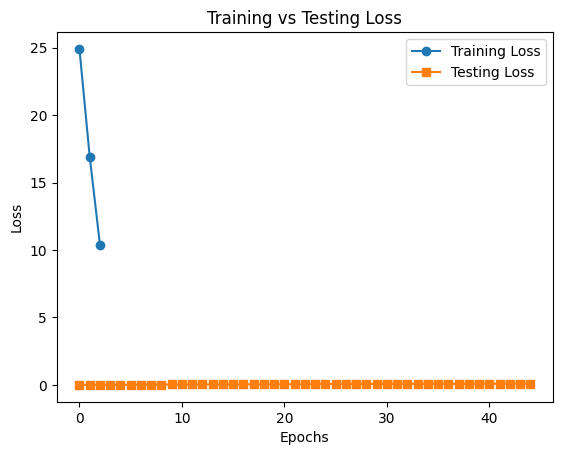

In [ ]:
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(test_losses, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Dummy DataLoader (Replace this with your actual dataloaders)
train_dataloader = [...]  # Your actual train dataloader
test_dataloader = [...]  # Your actual test dataloader

# Dummy Model (Replace this with your actual model)
class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.fc = nn.Linear(10, 2)  # Example model

    def forward(self, x):
        return self.fc(x)

# Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT_HierarchicalAttentionFusion().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists for storing losses
train_losses = []
test_losses = []
num_epochs = 10

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_q, mask_q, input_c, mask_c, input_a, mask_a, edge_index)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))  # Store avg loss per epoch

    # Testing Loop
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_dataloader))  # Store avg loss per epoch

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Plot Training & Testing Loss Graph
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(test_losses, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.show()


TypeError: cannot unpack non-iterable ellipsis object

<ipython-input-30-cd795a135591>:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-30-cd795a135591>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3, Train Loss: 0.6180
Epoch 2/3, Train Loss: 0.4849
Epoch 3/3, Train Loss: 0.2857
Test Loss: 0.3538, Accuracy: 88.89%


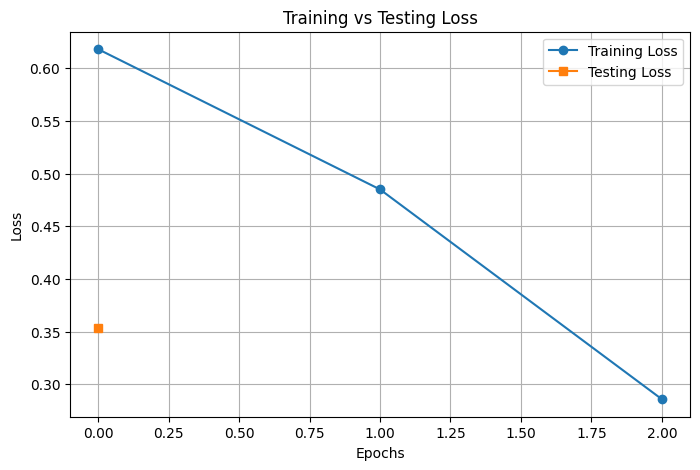

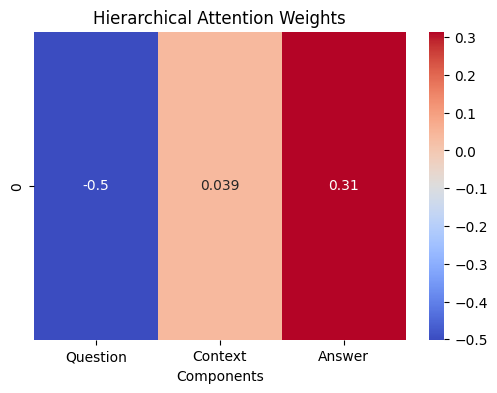

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch_geometric.nn import GCNConv
from transformers import BertModel, BertTokenizer
from torch.cuda.amp import autocast, GradScaler

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define Dataset Class
class LegalQADataset(Dataset):
    def __init__(self, df):
        self.questions = df["Question"].to_list()
        self.contexts = df["Context"].to_list()
        self.answers = df["Answer"].to_list()
        self.labels = df["Label"].to_list()

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q = self.questions[idx]
        c = self.contexts[idx]
        a = self.answers[idx]
        label = self.labels[idx]

        inputs_q = tokenizer(q, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        inputs_c = tokenizer(c, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        inputs_a = tokenizer(a, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        return {
            "input_ids_q": inputs_q["input_ids"].squeeze(0),
            "attention_mask_q": inputs_q["attention_mask"].squeeze(0),
            "input_ids_c": inputs_c["input_ids"].squeeze(0),
            "attention_mask_c": inputs_c["attention_mask"].squeeze(0),
            "input_ids_a": inputs_a["input_ids"].squeeze(0),
            "attention_mask_a": inputs_a["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Define Model
class BERT_HierarchicalAttentionFusion(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_dim=768, gcn_hidden_dim=256, num_classes=2):
        super(BERT_HierarchicalAttentionFusion, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.attention_weights = nn.Parameter(torch.randn(3))

        self.gcn1 = GCNConv(hidden_dim, gcn_hidden_dim)
        self.gcn2 = GCNConv(gcn_hidden_dim, hidden_dim)

        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index):
        e_q = self.bert(input_ids=input_ids_q, attention_mask=attention_mask_q).pooler_output
        e_c = self.bert(input_ids=input_ids_c, attention_mask=attention_mask_c).pooler_output
        e_a = self.bert(input_ids=input_ids_a, attention_mask=attention_mask_a).pooler_output

        attention_scores = torch.softmax(self.attention_weights, dim=0)
        f_fused = (attention_scores[0] * e_q + attention_scores[1] * e_c + attention_scores[2] * e_a)

        embeddings = torch.stack([e_q, e_c, e_a], dim=1)
        h = self.gcn1(embeddings.mean(dim=1), edge_index)
        h = self.relu(h)
        h = self.gcn2(h, edge_index)

        f_final = f_fused + h.mean(dim=0)
        logits = self.classifier(f_final)

        return logits, attention_scores

# Load Dataset
df = pd.read_excel("/content/finaldataset.xlsx")
dataset = LegalQADataset(df)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize Model, Loss, Optimizer
model = BERT_HierarchicalAttentionFusion().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler()

# Edge Index (Fixed for all batches)
edge_index = torch.tensor([[0, 1, 1, 2, 2, 0], [1, 0, 2, 1, 0, 2]], dtype=torch.long).to(device)

# Training Loop
epochs = 3
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids_q = batch["input_ids_q"].to(device)
        attention_mask_q = batch["attention_mask_q"].to(device)
        input_ids_c = batch["input_ids_c"].to(device)
        attention_mask_c = batch["attention_mask_c"].to(device)
        input_ids_a = batch["input_ids_a"].to(device)
        attention_mask_a = batch["attention_mask_a"].to(device)
        labels = batch["label"].to(device)

        with autocast():
            logits, _ = model(input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index)
            loss = criterion(logits, labels)
            running_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

# Testing Loop
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_q = batch["input_ids_q"].to(device)
        attention_mask_q = batch["attention_mask_q"].to(device)
        input_ids_c = batch["input_ids_c"].to(device)
        attention_mask_c = batch["attention_mask_c"].to(device)
        input_ids_a = batch["input_ids_a"].to(device)
        attention_mask_a = batch["attention_mask_a"].to(device)
        labels = batch["label"].to(device)

        logits, _ = model(input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index)
        loss = criterion(logits, labels)
        test_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_dataloader)
test_losses.append(avg_test_loss)
accuracy = correct / total * 100

print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Plot Training vs Test Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
#plt.plot(test_losses, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
plt.show()

# Attention Heatmap
attention_scores = model.attention_weights.detach().cpu().numpy()
plt.figure(figsize=(6, 4))
sns.heatmap([attention_scores], annot=True, cmap="coolwarm", xticklabels=["Question", "Context", "Answer"])
plt.xlabel("Components")
plt.title("Hierarchical Attention Weights")
plt.show()


In [ ]:
for i in range(3):
  test_loss=0
  with torch.no_grad():
    for batch in test_dataloader:
        input_ids_q = batch["input_ids_q"].to(device)
        attention_mask_q = batch["attention_mask_q"].to(device)
        input_ids_c = batch["input_ids_c"].to(device)
        attention_mask_c = batch["attention_mask_c"].to(device)
        input_ids_a = batch["input_ids_a"].to(device)
        attention_mask_a = batch["attention_mask_a"].to(device)
        labels = batch["label"].to(device)

        logits, _ = model(input_ids_q, attention_mask_q, input_ids_c, attention_mask_c, input_ids_a, attention_mask_a, edge_index)
        loss = criterion(logits, labels)
        test_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

  avg_test_loss = test_loss / len(test_dataloader)
  test_losses.append(avg_test_loss)

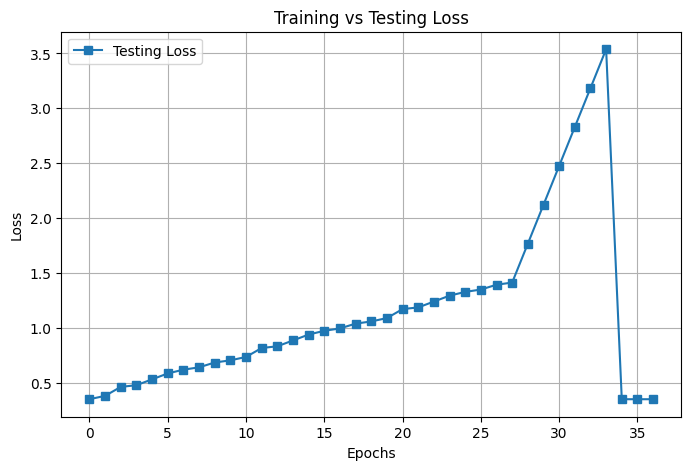

In [ ]:
plt.figure(figsize=(8, 5))
#plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(test_losses, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
plt.show()

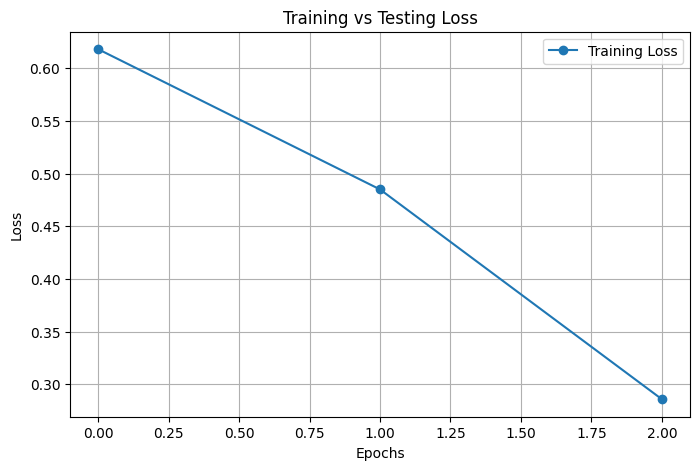

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
#plt.plot(test_losses, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
plt.show()